In [1]:
#Import libraries
from sklearn import preprocessing
%matplotlib inline
import pandas as pd
import numpy as np
from datetime import datetime
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import operator
import seaborn as sns

# seaborn graphing parameters
sns.set_style("whitegrid")
sns.set_palette("BuGn_r")
sns.set(font_scale=1.5) 

#ml algos
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

pd.options.display.max_rows = 30
pd.options.display.max_columns = 30

## This dataset measures data from Austin's dockless scooter & bike program from April 3, 2018 through June 18, 2019.

In [2]:
#import csv for private dockless rideshare co's
#commented out:
dockless = pd.read_csv('Dockless_Vehicle_Trips.csv', encoding='latin1')
#dockless = pd.read_pickle('./Dockless_Vehicle_Trips.pkl')
#dockless.to_pickle('./Dockless_Vehicle_Trips.pkl')

/Users/jakegrosek/miniconda3/envs/minimal_ds/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#bcycle = pd.read_pickle('./Austin_B-Cycle_Visualization.pkl')
#bcycle.to_pickle('./Austin_B-Cycle_Visualization.pkl')

# SECTION I: DATA CLEANING & EXPLORATION

## There are 5.44 millions dockless rides and a very small amount of rows with NaN's

In [4]:
# number of rides in the data
len(dockless)

5442039

In [5]:
# visual aid for the rows with NaN's
# relative to the bcycle data set, it is quite smaller
dockless.isnull().sum()

ID                            0
Device ID                     0
Vehicle Type                  1
Trip Duration                 1
Trip Distance                 1
Start Time                    1
End Time                      1
Modified Date                 0
Month                         1
Hour                          1
Day of Week                   1
Council District (Start)    186
Council District (End)      186
Year                          1
Census Tract Start          188
Census Tract End            188
dtype: int64

In [6]:
# instantiating a variable for the original number of rides 
# in the dataset (including NaN's)
dockless_rides = 5441283
print(dockless_rides)

5441283


## How many unique rows have NaN's ?

In [7]:
# confirmation all rows with NaN's are dropped
dockless.isnull().sum()

ID                            0
Device ID                     0
Vehicle Type                  1
Trip Duration                 1
Trip Distance                 1
Start Time                    1
End Time                      1
Modified Date                 0
Month                         1
Hour                          1
Day of Week                   1
Council District (Start)    186
Council District (End)      186
Year                          1
Census Tract Start          188
Census Tract End            188
dtype: int64

In [8]:
# instantiating the sum of all original NaN values
sum_of_dockless_nans = 1+1+1+1+1+1+1+1+186+186+1+188+188
sum_of_dockless_nans

757

In [9]:
# The number of NaN rides is 0.013% of the data set
sum_of_dockless_nans / dockless_rides

0.00013912160054898817

## 0.01% of the data contains NaN's. They will be dropped for now.

In [10]:
# drop rows with NaN's
dockless = dockless.dropna(axis=0)

In [11]:
# creating and printing the variable for the number of rides in the dataset without NaN's
dockless_no_nans = len(dockless)
print(dockless_no_nans)

5441851


In [12]:
nan_dockless_percent = sum_of_dockless_nans / dockless_rides
print("There are {} rides with NaN values out of {} total rides, which is equal to {}."
      .format(sum_of_dockless_nans, dockless_rides, nan_dockless_percent))

There are 757 rides with NaN values out of 5441283 total rides, which is equal to 0.00013912160054898817.


# Cleaning up columns

In [13]:
# data clean columns: 
dockless.columns = dockless.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

## Dropping the modified_date column since, according to the AustinTexas.gov website, is when "...the record was last modified (typically the date the data was extracted/loaded from the data provider), in local time (US/Central)."

In [14]:
dockless.drop(['modified_date'], axis=1, errors='coerce', inplace=True)

## Convert start/end time using to_datetime into a Unix timestamp

In [15]:
# create two new columns to convert the time values to unix
dockless['unix_start_time'] = dockless.start_time
dockless['unix_end_time'] = dockless.end_time

In [16]:
# set the parameter for how the date is being interpretted
merge_time_dock = datetime.strptime('04/29/2019 05:30:00 PM', '%m/%d/%Y %H:%M:%S %p')

# how i want the time coverted to (seconds)
merge_time_dock.strftime('%s')

# define unix timestamp function
def dockless_to_timestamp(str):
    merge_time_dock = datetime.strptime(str, '%m/%d/%Y %H:%M:%S %p')
    return merge_time_dock.strftime('%s')

In [17]:
# apply timestamp to new unix start time
dockless['unix_start_time'] = dockless.unix_start_time.apply(dockless_to_timestamp)

In [18]:
# apply timestamp to new unix end time
dockless['unix_end_time'] = dockless.unix_end_time.apply(dockless_to_timestamp)

In [19]:
# convert to integer
dockless['unix_start_time'] = pd.to_numeric(dockless['unix_start_time'], errors='ignore', downcast='integer')

In [20]:
# convert to integer
dockless['unix_end_time'] = pd.to_numeric(dockless['unix_end_time'], errors='ignore', downcast='integer')

## The Council Districts refer to the City of Austin's voting districts which are quite large and do not add helpful location data. Most rides started and ended in the same district, with the exception of District 0

In [21]:
dockless.council_district_start.value_counts()

9.0     4262555
3.0      498504
1.0      327468
5.0      189368
0.0       41656
7.0       37811
8.0       33117
10.0      28544
4.0       16669
2.0        5672
6.0         487
Name: council_district_start, dtype: int64

In [22]:
dockless.council_district_end.value_counts()

9.0     4191987
3.0      514803
1.0      362081
5.0      203877
7.0       38961
8.0       38768
10.0      32538
0.0       31674
4.0       19330
2.0        7348
6.0         484
Name: council_district_end, dtype: int64

In [23]:
# dropping Council District
dockless.drop(['council_district_start', 'council_district_end'], 1, inplace=True)

## Memory adjustments

In [24]:
# memory calculation for dockless data set
for dtype in ['float','int','object']:
    selected_dtype = dockless.select_dtypes(include=[dtype])
    mean_usage_b = selected_dtype.memory_usage(deep=True).mean()
    mean_usage_mb = mean_usage_b / 1024 ** 2
print("Average memory usage for {} columns: {:03.2f}MB".format(dtype,mean_usage_mb))

Average memory usage for object columns: 355.39MB


In [25]:
dockless.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5441851 entries, 2 to 5442038
Data columns (total 15 columns):
id                    object
device_id             object
vehicle_type          object
trip_duration         float64
trip_distance         float64
start_time            object
end_time              object
month                 float64
hour                  float64
day_of_week           float64
year                  float64
census_tract_start    object
census_tract_end      object
unix_start_time       int32
unix_end_time         int32
dtypes: float64(6), int32(2), object(7)
memory usage: 3.1 GB


## Converting ID and Device_ID to strings for consistency

In [26]:
dockless['id']= dockless['id'].astype(str)

In [27]:
dockless['device_id']= dockless['device_id'].astype(str)

## Convert columns to integers

In [28]:
dockless['trip_duration'] = pd.to_numeric(dockless['trip_duration'], errors='ignore', downcast='integer')

In [29]:
dockless['trip_distance'] = pd.to_numeric(dockless['trip_distance'], errors='ignore', downcast='integer')

In [30]:
dockless['month'] = pd.to_numeric(dockless['month'], errors='ignore', downcast='integer')

In [31]:
dockless['hour'] = pd.to_numeric(dockless['hour'], errors='ignore', downcast='integer')

In [32]:
dockless['day_of_week'] = pd.to_numeric(dockless['day_of_week'], errors='ignore', downcast='integer')

In [33]:
dockless['year'] = pd.to_numeric(dockless['year'], errors='ignore', downcast='integer')

In [34]:
dockless.dtypes

id                    object
device_id             object
vehicle_type          object
trip_duration          int32
trip_distance          int32
start_time            object
end_time              object
month                   int8
hour                    int8
day_of_week             int8
year                   int16
census_tract_start    object
census_tract_end      object
unix_start_time        int32
unix_end_time          int32
dtype: object

## ~95% of all dockless vehicle rides are Scooters

In [35]:
dockless.vehicle_type.value_counts(1)

scooter    0.95149
bicycle    0.04851
Name: vehicle_type, dtype: float64

## Drop GEO-ID columns since they provide location information and it is not the focus of this research project

In [36]:
dockless.drop(['census_tract_start'], axis=1, errors='coerce', inplace=True)

In [37]:
dockless.drop(['census_tract_end'], axis=1, errors='coerce', inplace=True)

## Create a column so time values are consistent in minutes and seconds in both datasets

In [38]:
dockless.rename(columns={'trip_duration':'trip_duration_seconds'}, inplace=True)

In [39]:
# dividing the number of seconds by 60
dockless['trip_duration_minutes'] = round((dockless['trip_duration_seconds'] / 60), 2)

## Negative time values

In [40]:
# identifying the number of rides with negative times
dockless[dockless['trip_duration_seconds']<0].count()

id                       7
device_id                7
vehicle_type             7
trip_duration_seconds    7
trip_distance            7
start_time               7
end_time                 7
month                    7
hour                     7
day_of_week              7
year                     7
unix_start_time          7
unix_end_time            7
trip_duration_minutes    7
dtype: int64

In [41]:
# instantiating the rows in the df with negative time
neg_time = dockless[dockless['trip_duration_seconds']<0].index.tolist()

# dropping the rows with negative time
dockless.drop(neg_time, axis=0, inplace=True)

## Negative distance values

In [42]:
# Similarly, some rows have a negative value for distance
dockless[dockless['trip_distance']<0].count()

id                       562
device_id                562
vehicle_type             562
trip_duration_seconds    562
trip_distance            562
start_time               562
end_time                 562
month                    562
hour                     562
day_of_week              562
year                     562
unix_start_time          562
unix_end_time            562
trip_duration_minutes    562
dtype: int64

In [43]:
# instantiating the rows in the df with negative distance
neg_distance = dockless[dockless['trip_distance']<0].index.tolist()

# dropping these rows
dockless.drop(neg_distance, axis=0, inplace=True)

## Creating formula for avg scooter distance

In [44]:
# convert meters to miles
# https://www.metric-conversions.org/length/meters-to-miles.htm
to_miles = 0.00062137

# Section II: Data Visualization & Exploration

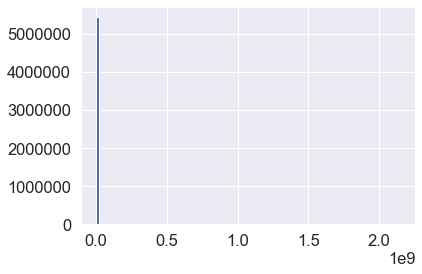

In [45]:
# outliers are deeply affecting the distribution
dockless.trip_distance.hist(bins=100)

## Limiting to 15,373.8 meters kept 99.9% of the ride data for analysis

In [46]:
# creating a new variable to capture the shortened distribution
df_distance = dockless.loc[(dockless['trip_distance'] <= 15373.8)]

# division of new variable up to 15,373.8 m divided by the total number of rides in the dataset
len(df_distance) / len(dockless)

0.9990950661994729

## Even after controlling for outliers, the distribution looks abnormal

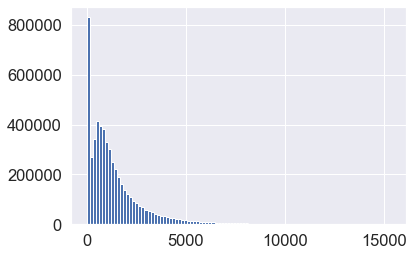

In [47]:
df_distance.trip_distance.hist(bins=100)

 # Furthermore, <1% of the rides extend beyond 8000 meters (4.87 mi)

In [48]:
# find the number of rides registering more than 8000 meters
dockless.loc[(dockless['trip_distance'] > 8000)].count()

id                       51174
device_id                51174
vehicle_type             51174
trip_duration_seconds    51174
trip_distance            51174
start_time               51174
end_time                 51174
month                    51174
hour                     51174
day_of_week              51174
year                     51174
unix_start_time          51174
unix_end_time            51174
trip_duration_minutes    51174
dtype: int64

In [49]:
51174 / len(df_distance)

0.009413287351568825

# Zeroing in on the abnormal distribution

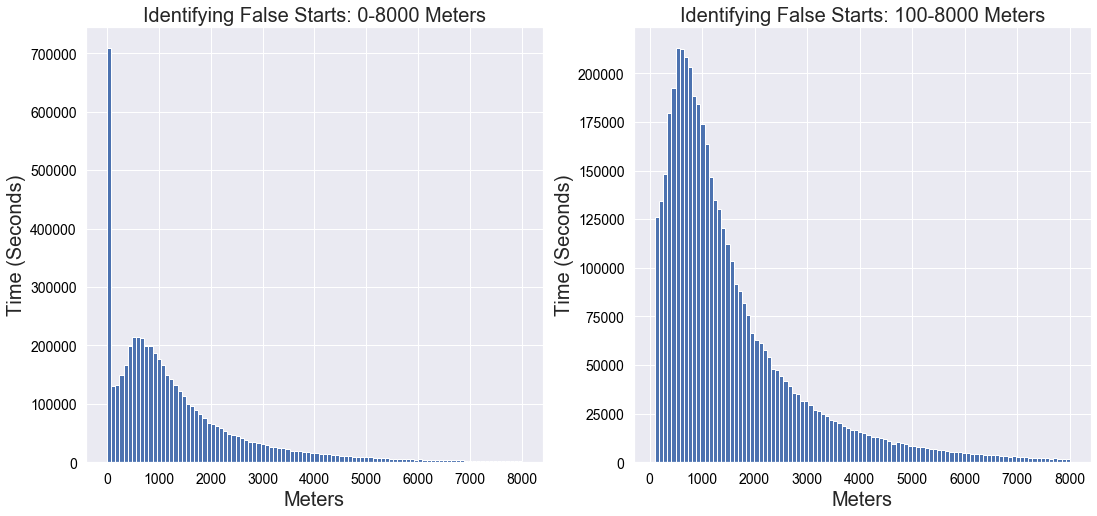

In [50]:
# limiting the distribution from 0-8000
plt.figure(figsize=[18,8])
plt.subplot(1, 2, 1, autoscale_on=True)  # 1 line, 2 rows, index nr 1 (first position in the subplot)
df_distance.trip_distance.hist(bins=100, range=(0,8000))
plt.title("Identifying False Starts: 0-8000 Meters",fontsize=20)
plt.ylabel("Time (Seconds)",fontsize=20) 
plt.xlabel("Meters",fontsize=20)
plt.tick_params(labelsize=14,labelcolor="black")

# limiting the distribution from 100-8000
# It looks more Poisson 
plt.subplot(1, 2, 2, autoscale_on=True)  # 1 line, 2 rows, index nr 2 (second position in the subplot)
df_distance.trip_distance.hist(bins=100, range=(100,8000))
plt.title("Identifying False Starts: 100-8000 Meters",fontsize=20)
plt.ylabel("Time (Seconds)",fontsize=20) 
plt.xlabel("Meters",fontsize=20)
plt.tick_params(labelsize=14,labelcolor="black")


plt.show()

## 1-100 and 1-10 was not as indicative

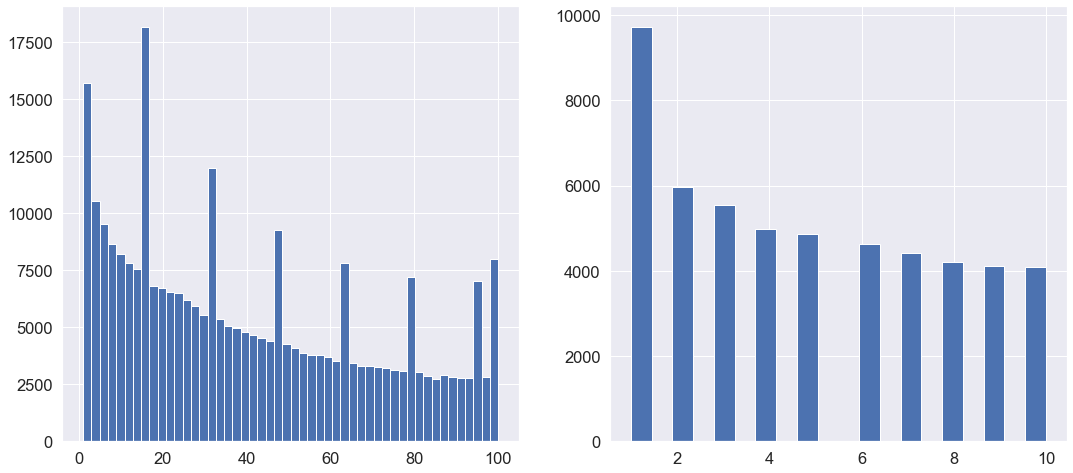

In [51]:
# set figure size
plt.figure(figsize=[18,8])

# first subplot 1-100
plt.subplot(1, 2, 1, autoscale_on=True)  # 1 line, 2 rows, index nr 1 (first position in the subplot)
df_distance.trip_distance.hist(bins=50, range=(1,100))

# second subplot 1-10
plt.subplot(1, 2, 2, autoscale_on=True)  # 1 line, 2 rows, index nr 2 (second position in the subplot)
df_distance.trip_distance.hist(bins=20, range=(1,10))

## Interestingly, the number of rides registering zero are solely responsible for the abnormal distribution

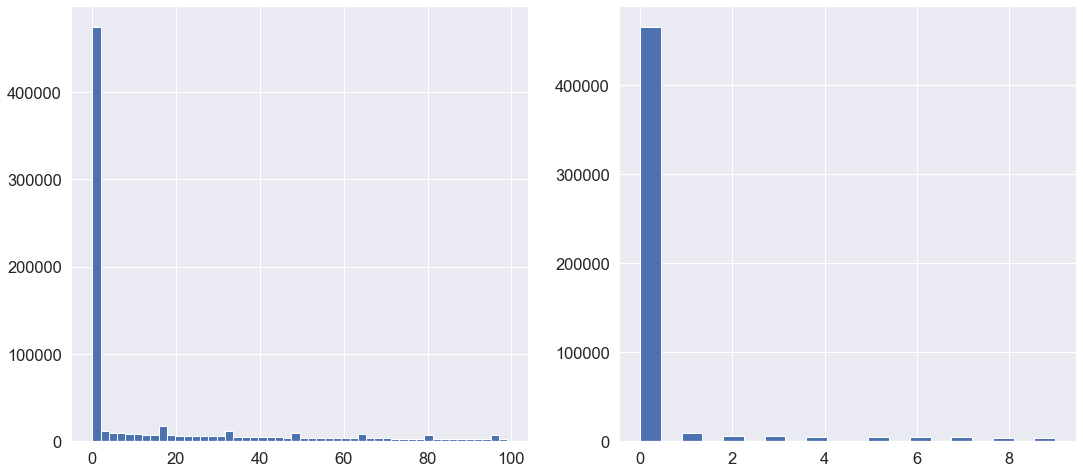

In [52]:
# set figure size
plt.figure(figsize=[18,8])

# first subplot 0-100
plt.subplot(1, 2, 1, autoscale_on=True)  # 1 line, 2 rows, index nr 1 (first position in the subplot)
df_distance.trip_distance.hist(bins=50, range=(0,99))

# second subplot 0-10
plt.subplot(1, 2, 2, autoscale_on=True)  # 1 line, 2 rows, index nr 2 (second position in the subplot)
df_distance.trip_distance.hist(bins=20, range=(0,9))

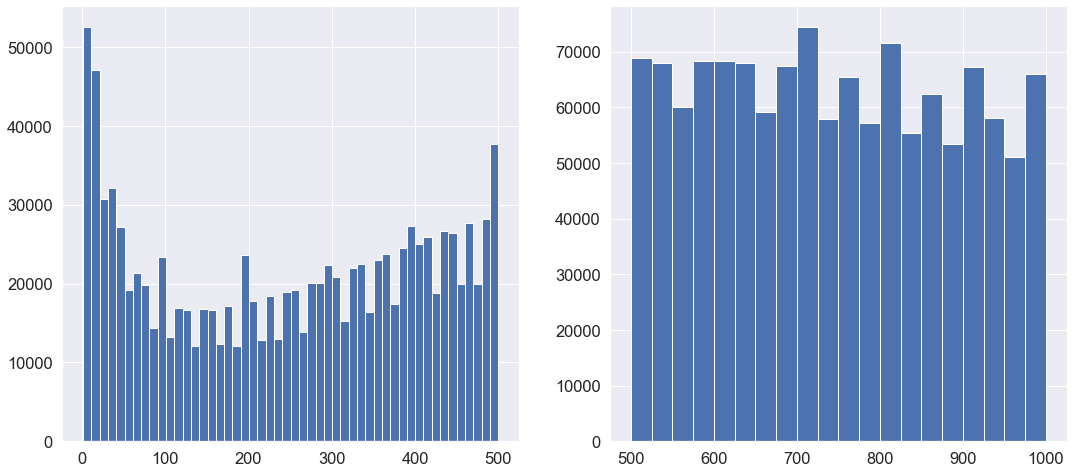

In [53]:
# set figure size
plt.figure(figsize=[18,8])

# first subplot 1-500
plt.subplot(1, 2, 1, autoscale_on=True)  # 1 line, 2 rows, index nr 1 (first position in the subplot)
df_distance.trip_distance.hist(bins=50, range=(1,500))

# second subplot 500-1000
plt.subplot(1, 2, 2, autoscale_on=True)  # 1 line, 2 rows, index nr 2 (second position in the subplot)
df_distance.trip_distance.hist(bins=20, range=(500,1000))

# Introducing the hypothesis of the "false start."

In [54]:
# instantiating a range between rides >= to 1 and <= 16000 meters
normal_dockless_rides = dockless.loc[(dockless['trip_distance'] >= 1) & 
                                     (dockless['trip_distance'] <= 16000)]

len(normal_dockless_rides)

4972377

In [55]:
# instantiating a range between rides >= to 1 and <= 16000 meters
outlier_dockless_rides = dockless.loc[(dockless['trip_distance'] == 0) | 
                                     (dockless['trip_distance'] > 16000)]

len(outlier_dockless_rides)

468905

In [56]:
# calculating "real rides"
rr = len(normal_dockless_rides) / len(dockless)
rr

0.9138245362030492

In [57]:
# calculating "false starts"
false_rides = dockless.loc[(dockless['trip_distance'] < 1)]
len(false_rides)

464633

# Incredibly, almost 1 in 10 rides (8.5%) are registering zero distance

In [58]:
fr = len(false_rides) / len(dockless)
fr

0.08539035469949913

## Furthermore, 0.07% of all rides in the data traveled more than 16,000 meters (9.94 miles!)

In [59]:
# instantiating rides > 16000 meters
extreme_rides = dockless.loc[(dockless['trip_distance'] > 16000)]

len(extreme_rides) / len(dockless)

0.0007851090974516667

## The distribution of rides between bikes and scooters

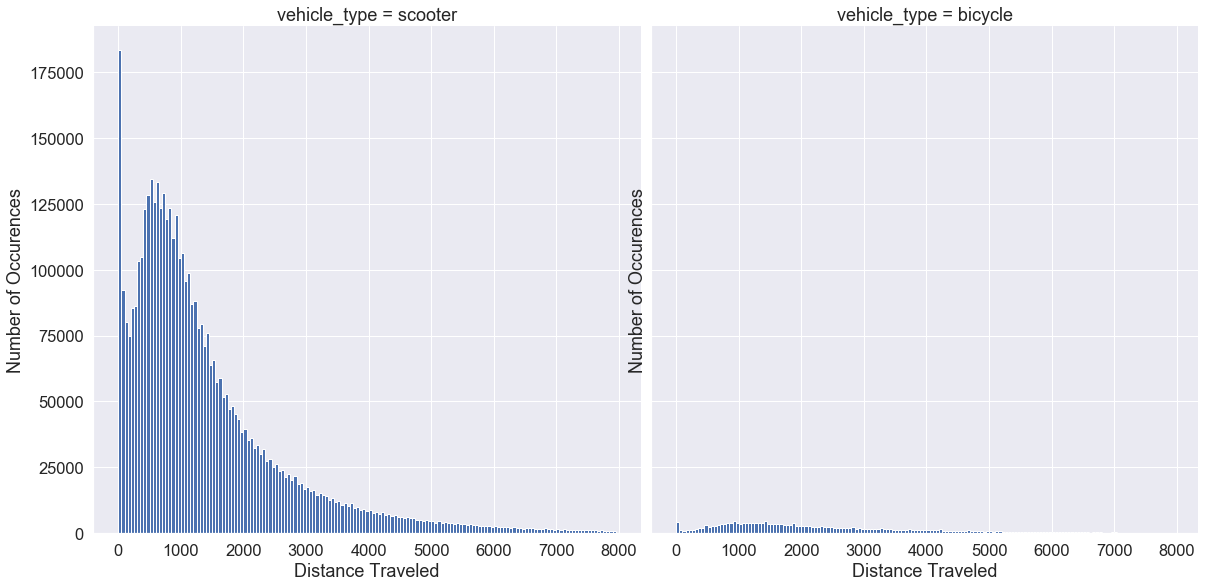

In [60]:
bins = np.arange(0, 8000, 50)
# using FacetGrid to show the rides by category 'vehicle type'
dockless_types = sns.FacetGrid(normal_dockless_rides, col='vehicle_type', height=8.27)
dockless_types.map(plt.hist, "trip_distance", bins=bins)
dockless_types.set(xlabel='Distance Traveled', ylabel='Number of Occurences')
plt.show()

In [61]:
# instantiating a new df for "real" scooter rides
normal_dockless_rides_s = dockless.loc[(dockless['trip_distance'] >= 1)
                                    & (dockless['trip_distance'] <= 16000)
                                    & (dockless['vehicle_type'] == 'scooter')
                                    & (dockless['trip_duration_seconds'] >= 1)]


In [62]:
# instantiating a new df for "real" bike rides
normal_dockless_rides_b = dockless.loc[(dockless['trip_distance'] >= 1)
                                    & (dockless['trip_distance'] <= 16000)
                                    & (dockless['vehicle_type'] == 'bicycle')
                                    & (dockless['trip_duration_seconds'] >= 1)]

## It appears that while both have similar distribution shapes, the bike rides tend to cover longer distances

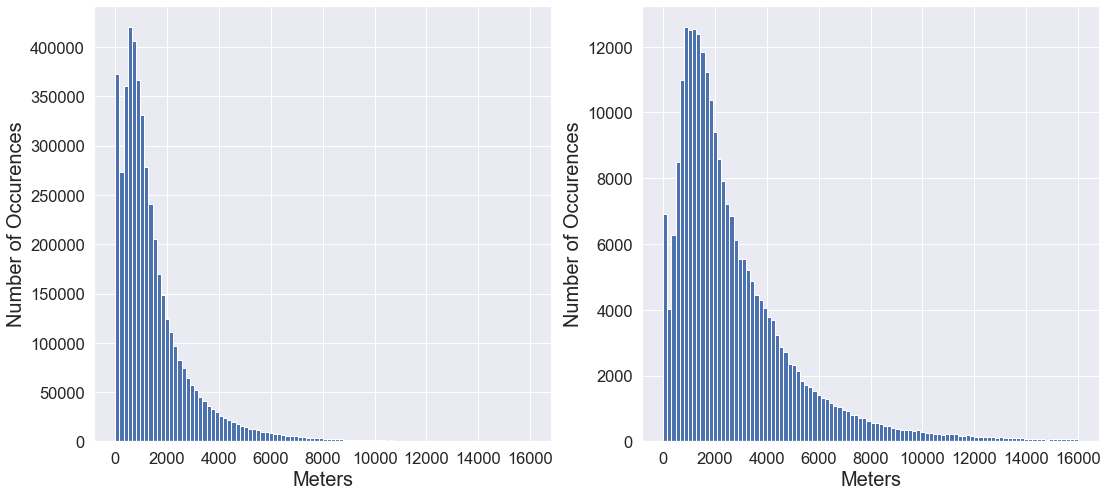

In [63]:
plt.figure(figsize=[18,8])

# scooter plot
plt.subplot(1, 2, 1, autoscale_on=True)  # 1 line, 2 rows, index nr 1 (first position in the subplot)
normal_dockless_rides_s.trip_distance.hist(bins=100)
plt.ylabel("Number of Occurences",fontsize=20) 
plt.xlabel("Meters",fontsize=20)

# bike plot
plt.subplot(1, 2, 2, autoscale_on=True)  # 1 line, 2 rows, index nr 2 (second position in the subplot)
normal_dockless_rides_b.trip_distance.hist(bins=100)
plt.ylabel("Number of Occurences",fontsize=20) 
plt.xlabel("Meters",fontsize=20)

plt.show()

## Day of Week analysis by vehicle type

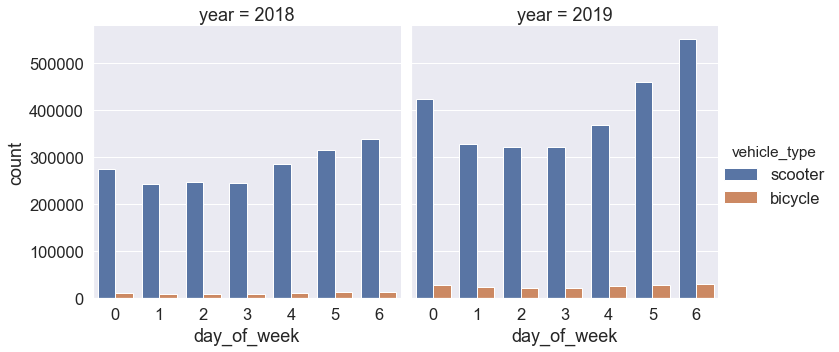

In [64]:
sns.catplot(x="day_of_week", hue="vehicle_type", col='year', 
            data=normal_dockless_rides, kind='count')

## Even though the data from 2019 has three fewer months worth compared to 2018, there is about  ~50% more data which speaks to the increased adoption rate in the city.

In [65]:
count_2018 = len(normal_dockless_rides.loc[(normal_dockless_rides['year'] == 2018)])
count_2019 = len(normal_dockless_rides.loc[(normal_dockless_rides['year'] == 2019)])

print("The total number of real rides in 2018 was {}.".format(count_2018))
print("The total number of real rides in 2019 was {}.".format(count_2019))

The total number of real rides in 2018 was 2021919.
The total number of real rides in 2019 was 2950458.


# Understanding usage by unique devices

## Since each device has its own unique identifying code, it is possible to measure and compare usage.
## The most used device was riden 693 times.

In [66]:
# created a new variable for how frequently unique devices were used
device_freq = dockless.device_id.value_counts()
device_freq

e9de6733-842d-46c6-bdec-2b1bb3ce6e78    693
c501eef0-c361-4c25-9489-acaff8a3eeeb    679
6cb1120f-282a-4894-89e7-395a13b1f1d0    647
460665fe-f0b7-4fb8-a537-50b5e33cf066    640
fa8de131-5904-4daa-8483-52ab9fea3e86    635
                                       ... 
527ac062-4763-43c6-b21e-da20bf4fea62      1
a1f50f1c-e30a-450c-afba-091b81c6dfeb      1
6dcdf6bf-0283-4aab-a9b9-cc7cef9e602f      1
22f5a83a-e7c2-4ded-9833-f0f9a5efd434      1
76e22406-f3fc-4136-bfd2-d01ede917daa      1
Name: device_id, Length: 48761, dtype: int64

## Similar to the distance distribution, scooter usage also has a long tail. 

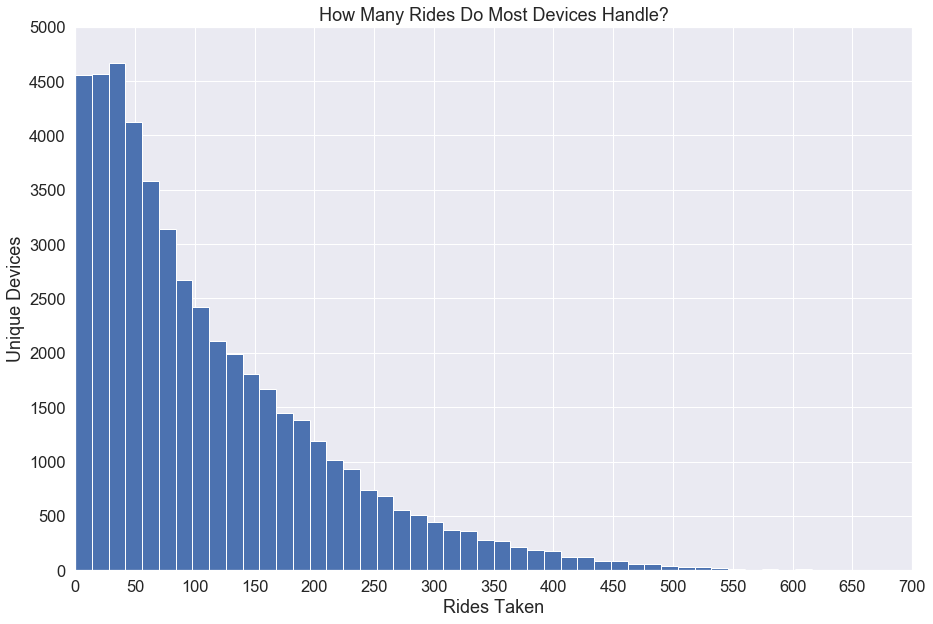

In [67]:
# The full distribution
plt.figure(figsize=[15, 10])
d_id_plot = device_freq.hist(bins=50, range=(0, 700))
plt.title('How Many Rides Do Most Devices Handle?')
plt.xlabel('Rides Taken')
plt.ylabel('Unique Devices')
unique_devices = d_id_plot.set(xlim=(0,700),
                ylim=(0,5000),
                xticks=[0,50, 100, 150, 200, 250, 300, 350,
                        400, 450, 500, 550, 600, 650, 700],
                yticks=[0, 500, 1000, 1500, 2000, 2500, 3000, 3500,
                        4000, 4500, 5000])


## How many scooters had a false starts compared to bikes?

In [68]:
# instantiate parameters for calculating % of false starts
mask_false_start = dockless.trip_distance == 0
mask_scooter = dockless.vehicle_type == 'scooter'
mask_bike = dockless.vehicle_type == 'bicycle'

In [69]:
# number of scooters responsible for "false starts" 
dockless_false_start_s = dockless[mask_false_start & mask_scooter] 
dsfs = len(dockless_false_start_s)
dsfs

455094

In [70]:
# number of bikes responsible for "false starts" 
dockless_false_start_b = dockless[mask_false_start & mask_bike] 
dbfs = len(dockless_false_start_b)
dbfs

9539

In [71]:
fs = len(false_rides)
dsfs_percent = dsfs / fs
dbfs_percent = dbfs / fs
print("""Of {} rides categorized as "false starts," scooters were responsible for {} rides, 
while bikes were responsble for {} rides.""".format(fs, dsfs, dbfs))
# 97.9% of false starts are during scooter rides
print("""\nScooters false start percentage: {}""".format(dsfs_percent))
# 2.05% of false starts are during bike rides
print("""Bikes false start percentage: {}""".format(dbfs_percent))

Of 464633 rides categorized as "false starts," scooters were responsible for 455094 rides, 
while bikes were responsble for 9539 rides.

Scooters false start percentage: 0.9794698181145118
Bikes false start percentage: 0.020530181885488115


# Pickle the notebook

In [72]:
# create a new csv file with cleaned data
dockless.to_csv('dockless_cleaned')

# pickle the file
dockless.to_pickle('./dockless_cleaned.pkl')

# commented out; read the pickled fule
#dockless = pd.read_pickle('./Dockless_Vehicle_Trips.pkl')


# Information about scooter & bike providers, permit totals, manufacturers, and other figures (not pickled)

In [ ]:
## Listing the different scooter & bike manufacturers with their respectives ranges based on one full battery charge

# different manufactured types of scooters or bike w/ their ranges in miles based on one full battery charge
xiaomi = 15
jump_bike = 40
lime_s = 37
vespa = 50
veo_bike = 68

## List of all dockless companies with permits and ranges calculated

# Bird permits and scooter range
bird_permits_scooter = 1000
bird_range_scooter = xiaomi 

# JUMP permits and scooter/bike ranges
jump_permits_scooter = 500
jump_permits_bike = 500

jump_range_scooter = xiaomi 
jump_range_bike = jump_bike 

# Lime scooter permits and range
lime_permits_scooter = 500
lime_range_scooter = lime_s 

# Lyft scooter permits and range
lyft_permits_scooter = 500
lyft_range_scooter = xiaomi

# OjO scooter permits and range
ojo_permits_scooter = 100
ojo_range_scooter = vespa 

# Skip scooter permits and range
skip_permits_scooter = 500
skip_range_scooter = vespa 

# Spin scooter permits and range
spin_permits_scooter = 500
skip_range_scooter = xiaomi

# VeoRide scooter & bike permits and range
veo_permits_scooter = 300
veo_permits_bike = 50

veo_range_scooter = xiaomi 
veo_range_bike = veo_bike

## Permit Totals

# formula for scooter permits
total_scooter_permits = (bird_permits_scooter + 
                         jump_permits_scooter + 
                         lime_permits_scooter + 
                         lyft_permits_scooter +
                         ojo_permits_scooter +
                         skip_permits_scooter + 
                         spin_permits_scooter + 
                         veo_permits_scooter)
print(total_scooter_permits)

#formula for bike permits
total_bike_permits = (jump_permits_bike + veo_permits_bike)
print(total_bike_permits)

## Permit Percentages

# formulas for scooter weighted avg
bird_s_pct = bird_permits_scooter / total_scooter_permits
jump_s_pct = jump_permits_scooter / total_scooter_permits
lime_s_pct = lime_permits_scooter / total_scooter_permits
lyft_s_pct = lyft_permits_scooter / total_scooter_permits
ojo_s_pct = ojo_permits_scooter / total_scooter_permits
skip_s_pct = skip_permits_scooter / total_scooter_permits
spin_s_pct = spin_permits_scooter / total_scooter_permits
veo_s_pct = veo_permits_scooter / total_scooter_permits

# formulas for bike weighted avg
jump_b_pct = jump_permits_bike / total_bike_permits
veo_b_pct = veo_permits_bike / total_bike_permits
print(jump_b_pct)
print(veo_b_pct)

permit_totals = [bird_permits_scooter, jump_permits_scooter, lime_permits_scooter, lyft_permits_scooter,
                        ojo_permits_scooter, skip_permits_scooter, spin_permits_scooter, veo_permits_scooter]

for permit in permit_totals:
    print(permit / total_scooter_permits)